# **Mount Drive**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [2]:
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter, defaultdict

import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

!pip install umap-learn
import umap

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00


In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# **Load Text8**

In [4]:
def load(path):
  with open(path, 'r') as file:
    text8 = file.read()

  return text8

# **Preprocess Text**

In [5]:
def preprocess(text8, min_length, min_frequency):
  # Tokenize
  print("Tokenizing text...")
  tokens = nltk.word_tokenize(text8)

  # Remove stopwords
  print("Removing stop words...")
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  # Remove numbers
  print("Removing numbers...")
  numbers = {"zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"}
  tokens = [word for word in tokens if word not in numbers]

  # Lemmatize tokens
  print("Lemmatizing words...")
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Keep nouns, adjectives and verbs
  print("Keeping nouns, adjectives, and verbs...")
  pos_tags = nltk.pos_tag(tokens)
  tokens = [word for word, pos in pos_tags if pos.startswith(('NN', 'JJ', 'VB'))]

  # Remove words of a given length
  print(f"Filtering words with {min_length} < length...")
  tokens = [word for word in tokens if min_length < len(word)]

  # Remove infrequent words
  print(f"Removing infrequent words ({min_frequency} < frequency)...")
  word_frequency = Counter(tokens)
  tokens = [word for word in tokens if min_frequency < word_frequency[word]]

  return tokens

# **Build Co-Occurrence Matrix**

In [6]:
def build_co_matrix(words, window_size):
  # Create a list of co-occurring word pairs
  co_occurrences = defaultdict(Counter)
  for i, word in enumerate(words):
    for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
      if i != j:
        co_occurrences[word][words[j]] += 1

  # Create a list of unique words
  unique_words = list(set(words))

  # Initialize the co-occurrence matrix
  co_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

  # Populate the co-occurrence matrix
  word_index = {word: idx for idx, word in enumerate(unique_words)}
  for word, neighbors in co_occurrences.items():
    for neighbor, count in neighbors.items():
      co_matrix[word_index[word]][word_index[neighbor]] = count

  # Create a DataFrame for better readability
  co_matrix_df = pd.DataFrame(co_matrix, index=unique_words, columns=unique_words)

  # Convert the above matrix to sparse representation, saves memory
  sparse_co_matrix = csr_matrix(co_matrix_df)

  return sparse_co_matrix

# **Apply K-Means**

In [7]:
def apply_kmeans(matrix, clusters, folds):
  # Experiment with different numbers of clusters
  k_values = range(2, clusters+1)

  # Mean metrics
  mean_inertia_scores = []
  mean_silhouette_scores = []
  mean_davies_bouldin_scores = []
  mean_calinski_harabasz_scores = []

  # Initialize K-Fold cross-validation
  kf = KFold(n_splits=folds, shuffle=True, random_state=42)

  for k in k_values:
    print(f"Cluster Number: {k}")

    # Metrics
    inertia_scores = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    for train_index, test_index in kf.split(matrix):
      # Store training set and testing set
      train_matrix = matrix[train_index]
      test_matrix = matrix[test_index]

      # Perform K-Means clustering
      kmeans = KMeans(n_clusters=k, random_state=42)
      labels = kmeans.fit(train_matrix)

      # Inertia on testing set
      test_labels = kmeans.predict(test_matrix)
      assigned_centroids = kmeans.cluster_centers_[test_labels]
      squared_differences = np.sum((test_matrix - assigned_centroids) ** 2, axis=1)
      inertia = np.sum(squared_differences)

      # Metrics on testing set
      inertia_scores.append(inertia)
      silhouette_scores.append(silhouette_score(test_matrix, test_labels))
      davies_bouldin_scores.append(davies_bouldin_score(test_matrix, test_labels))
      calinski_harabasz_scores.append(calinski_harabasz_score(test_matrix, test_labels))

    # Store mean results
    mean_inertia_scores.append(np.mean(inertia_scores))
    mean_silhouette_scores.append(np.mean(silhouette_scores))
    mean_davies_bouldin_scores.append(np.mean(davies_bouldin_scores))
    mean_calinski_harabasz_scores.append(np.mean(calinski_harabasz_scores))

  # Plot the elbow method
  plt.figure(figsize=(16, 10))
  plt.subplot(2, 2, 1)
  plt.plot(k_values, mean_inertia_scores, marker='o')
  plt.title("Elbow Method")
  plt.xlabel("Number of clusters")
  plt.ylabel("Inertia")

  # Plot the silhouette score
  plt.subplot(2, 2, 2)
  plt.plot(k_values, mean_silhouette_scores, marker='o')
  plt.title("Silhouette Score")
  plt.xlabel("Number of clusters")
  plt.ylabel("Silhouette Score")

  # Plot the Davies-Bouldin index
  plt.subplot(2, 2, 3)
  plt.plot(k_values, mean_davies_bouldin_scores, marker='o')
  plt.title("Davies-Bouldin Index")
  plt.xlabel("Number of clusters")
  plt.ylabel("Davies-Bouldin Index")

  # Plot the Calinski-Harabasz index
  plt.subplot(2, 2, 4)
  plt.plot(k_values, mean_calinski_harabasz_scores, marker='o')
  plt.title("Calinski-Harabasz Index")
  plt.xlabel("Number of clusters")
  plt.ylabel("Calinski-Harabasz Index")

  plt.tight_layout()
  plt.show()

# **Analyze Clustering**

In [8]:
def visualise_clustering(matrix, labels):
  # Scatter plot
  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(matrix[:, 0], matrix[:, 1], c=labels, cmap='tab10', alpha=0.7, edgecolor='k')

  # Add a colorbar if you want
  plt.colorbar(scatter, label='Cluster')

  # Labels and title
  plt.title('UMAP Clustering Visualization')
  plt.xlabel('UMAP Dimension 1')
  plt.ylabel('UMAP Dimension 2')

  # Show the plot
  plt.show()

In [9]:
def display_words(words, labels):
  # Group words by their cluster labels
  clusters = {}
  for word, label in zip(words, labels):
    if label not in clusters:
      clusters[label] = []
    clusters[label].append(word)

  # Display words in each cluster
  for cluster_label, cluster_words in clusters.items():
    print(f"Cluster {cluster_label}: {', '.join(cluster_words)}")

# **Main Pipeline**

In [10]:
# Load dataset
text8_path = '/content/drive/MyDrive/text8'
text8 = load(text8_path)

In [11]:
# Preprocess text
tokens = preprocess(text8, 2, 50)
print(len(tokens))

# Store vocabulary
vocab = list(set(tokens))
print(len(vocab))

Tokenizing text...
Removing stop words...
Removing numbers...
Lemmatizing words...
Keeping nouns, adjectives, and verbs...
Filtering words with 2 < length...
Removing infrequent words (50 < frequency)...
7116175
14942


In [12]:
# Build co-occurrence matrix
co_matrix = build_co_matrix(tokens, 2).toarray()
print(co_matrix.shape)

(14942, 14942)


In [13]:
# Normalize co-occurrence matrix
normalized_matrix = normalize(co_matrix, norm='l2', axis=1)
print(normalized_matrix.shape)

(14942, 14942)


In [14]:
# Reduce co-occurence matrix
reducer = umap.UMAP(n_neighbors=30, n_components=2, random_state=42)
reduced_matrix = reducer.fit_transform(normalized_matrix)
print(reduced_matrix.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(14942, 2)


Cluster Number: 2
Cluster Number: 3
Cluster Number: 4
Cluster Number: 5
Cluster Number: 6
Cluster Number: 7
Cluster Number: 8
Cluster Number: 9
Cluster Number: 10
Cluster Number: 11
Cluster Number: 12
Cluster Number: 13
Cluster Number: 14
Cluster Number: 15
Cluster Number: 16
Cluster Number: 17
Cluster Number: 18
Cluster Number: 19
Cluster Number: 20
Cluster Number: 21
Cluster Number: 22
Cluster Number: 23
Cluster Number: 24
Cluster Number: 25
Cluster Number: 26
Cluster Number: 27
Cluster Number: 28
Cluster Number: 29
Cluster Number: 30


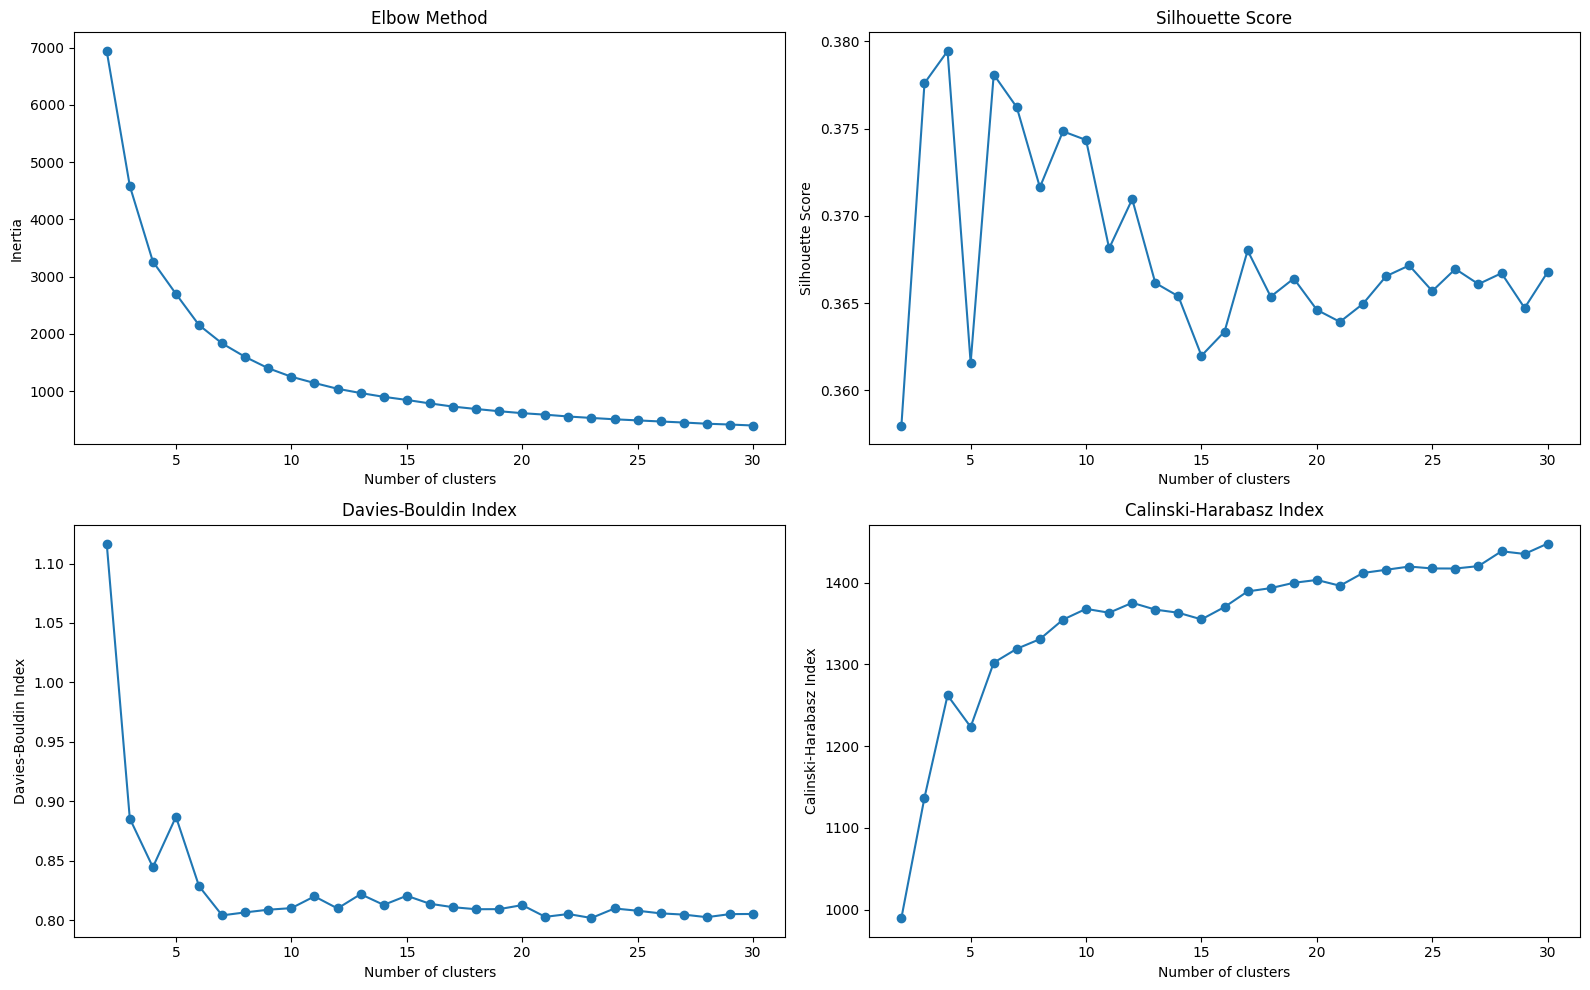

In [15]:
# Apply K-Means
apply_kmeans(reduced_matrix, 30, 10)

In [16]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(reduced_matrix)

KMeans(n_clusters=6, random_state=42)

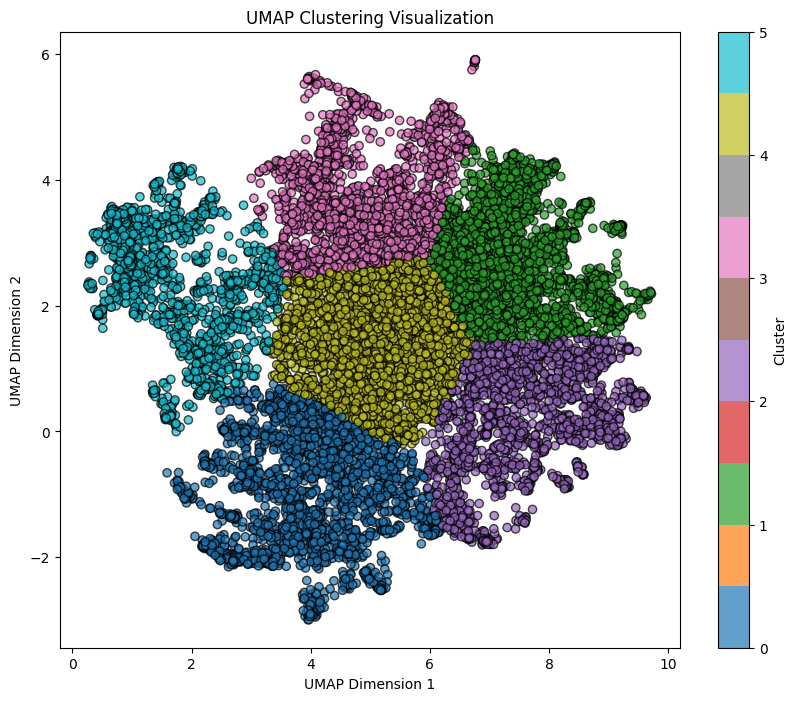

In [17]:
visualise_clustering(reduced_matrix, kmeans.labels_)

In [18]:
display_words(vocab, kmeans.labels_)

Cluster 0: seneca, lewinsky, warring, renovation, mauritania, uganda, monetary, basement, encompassed, bavaria, essex, baku, auckland, cpc, iaea, downstream, university, wellington, chartered, brandenburg, shipyard, nassau, idaho, port, vietnamese, arkansas, saunders, dalhousie, observer, flanders, sudan, ifad, col, depleted, spotlight, former, potsdam, hochschule, cyrenaica, croatian, shoreline, italy, argentina, wide, cartier, surveyed, vacant, inductee, staff, brighton, unanimous, coco, garden, arlington, hannibal, negotiated, anchorage, centred, asia, nagasaki, qaeda, colombia, leadership, drained, slope, swabia, ethiopia, nevada, aftermath, jordan, richmond, kgb, polish, appalachian, suez, ole, nord, citadel, socialist, thrace, fao, mile, rhode, overlooking, ceuta, journalism, yamamoto, hegemony, denver, ministerial, grove, bengal, schleswig, belle, sarajevo, yugoslavia, voivodship, flooding, peacetime, tenure, bradford, contempt, longest, parking, confederacy, appealed, ensued, v